# Multi-Layer Perceptron, MNIST 

---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [1]:
# import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 100 # 100

# Apply pre-processing transforms
resized_img_size = 14 # square
# (downscale the image from 28*28 to 20*20)
transform = transforms.Compose(
    [transforms.Resize(size=(resized_img_size, resized_img_size)), 
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])# (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

/home/ruthwik/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

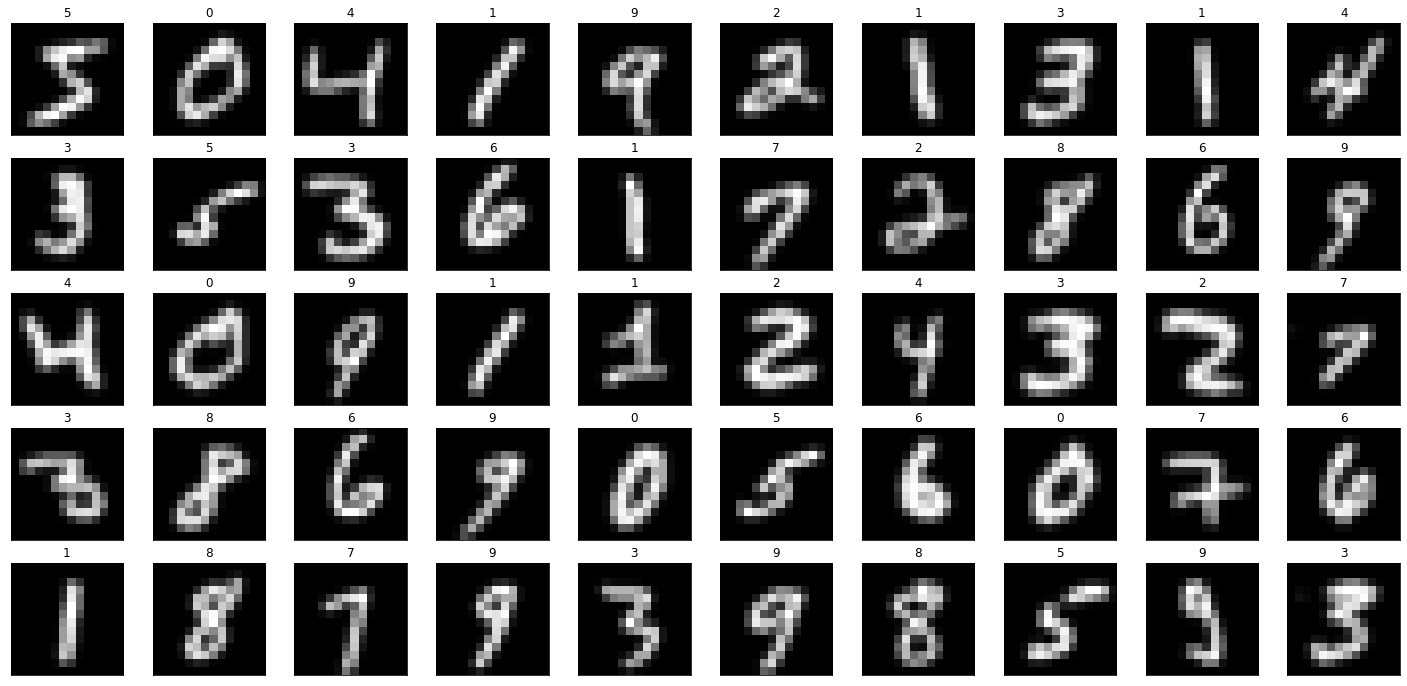

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 12))
for idx in np.arange(min(batch_size, 50)):
    ax = fig.add_subplot(5, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(resized_img_size*resized_img_size, 64) # nn.Linear(28 * 28, 1000)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)


    def forward(self, x):
        # flatten image input
        x = x.view(-1, resized_img_size * resized_img_size)
        x = F.relu(self.fc1(x))
        # x=F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # torch.sigmoid(self.fc3(x))
        # x=F.dropout(x, p=0.5, training=self.training)
        return x
        # return x

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

In [8]:
from ADAM import ADAM

In [9]:
trainingLoss = {}
# Fixed seed for random weight initialization (to keep the weights same for all
# the models)
# seed = 11 



def trainDifOptimizer(optmzr):
    # torch.manual_seed(seed)
    model = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = None
    if optmzr=='Adam_scratch':
      optimizer = ADAM(model.parameters(), lr=0.01) # lr=0.001 -> standard
    else:
      optimizer = getattr(torch.optim, optmzr)(model.parameters(), lr=0.01)
    
    n_epochs = 15  # suggest training between 20-50 epochs

    model.train()  # prep model for training
    trainLossForOptimizer = []
    print("Optimizer : ", optmzr, "\n")
    for epoch in range(n_epochs):
        train_loss = 0.0

        for data, target in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*data.size(0)

        # print training statistics
        # calculate average loss over an epoch
        train_loss = train_loss/len(train_loader.dataset)
        trainLossForOptimizer.append(train_loss)
        
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch+1,
            train_loss
        ))
    torch.save(model, 'saved_models/'+optmzr+'_model')
    trainingLoss[optmzr] = trainLossForOptimizer
    print("\n-----------------------------------------\n")

optimizersLst = ['Adam', 'RMSprop','SGD','Adadelta','Adam_scratch']

for optmzr in optimizersLst:
    trainDifOptimizer(optmzr)

print(trainingLoss)
  

Optimizer :  Adam 

Epoch: 1 	Training Loss: 0.450297
Epoch: 2 	Training Loss: 0.245149
Epoch: 3 	Training Loss: 0.207811
Epoch: 4 	Training Loss: 0.197551
Epoch: 5 	Training Loss: 0.188814
Epoch: 6 	Training Loss: 0.172060
Epoch: 7 	Training Loss: 0.172440
Epoch: 8 	Training Loss: 0.165529
Epoch: 9 	Training Loss: 0.160727
Epoch: 10 	Training Loss: 0.156326
Epoch: 11 	Training Loss: 0.151803
Epoch: 12 	Training Loss: 0.150983
Epoch: 13 	Training Loss: 0.147488
Epoch: 14 	Training Loss: 0.145108
Epoch: 15 	Training Loss: 0.140540

-----------------------------------------

Optimizer :  RMSprop 

Epoch: 1 	Training Loss: 0.735233
Epoch: 2 	Training Loss: 0.309078
Epoch: 3 	Training Loss: 0.257040
Epoch: 4 	Training Loss: 0.231399
Epoch: 5 	Training Loss: 0.219356
Epoch: 6 	Training Loss: 0.210974
Epoch: 7 	Training Loss: 0.202038
Epoch: 8 	Training Loss: 0.196806
Epoch: 9 	Training Loss: 0.192507
Epoch: 10 	Training Loss: 0.190021
Epoch: 11 	Training Loss: 0.185895
Epoch: 12 	Training L

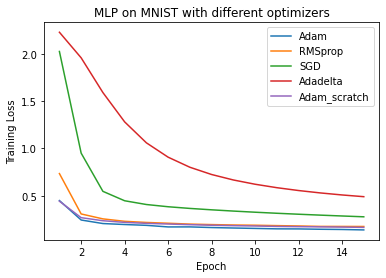

In [10]:
Xval = np.arange(1, 16)

plt.xlabel("Epoch")  # add X-axis label
plt.ylabel("Training Loss")  # add Y-axis label
plt.title("MLP on MNIST with different optimizers")  # add title

for key, value in trainingLoss.items():
    plt.plot(Xval, value, label=key)

plt.legend()
plt.show()

---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

#### `model.eval()`

`model.eval(`) will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [46]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model = torch.load('saved_models/RMSprop_model')
criterion = nn.CrossEntropyLoss()
model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.294095

Test Accuracy of     0: 98% (961/980)
Test Accuracy of     1: 98% (1115/1135)
Test Accuracy of     2: 92% (951/1032)
Test Accuracy of     3: 96% (970/1010)
Test Accuracy of     4: 94% (930/982)
Test Accuracy of     5: 85% (760/892)
Test Accuracy of     6: 92% (883/958)
Test Accuracy of     7: 72% (746/1028)
Test Accuracy of     8: 92% (903/974)
Test Accuracy of     9: 94% (958/1009)

Test Accuracy (Overall): 91% (9177/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

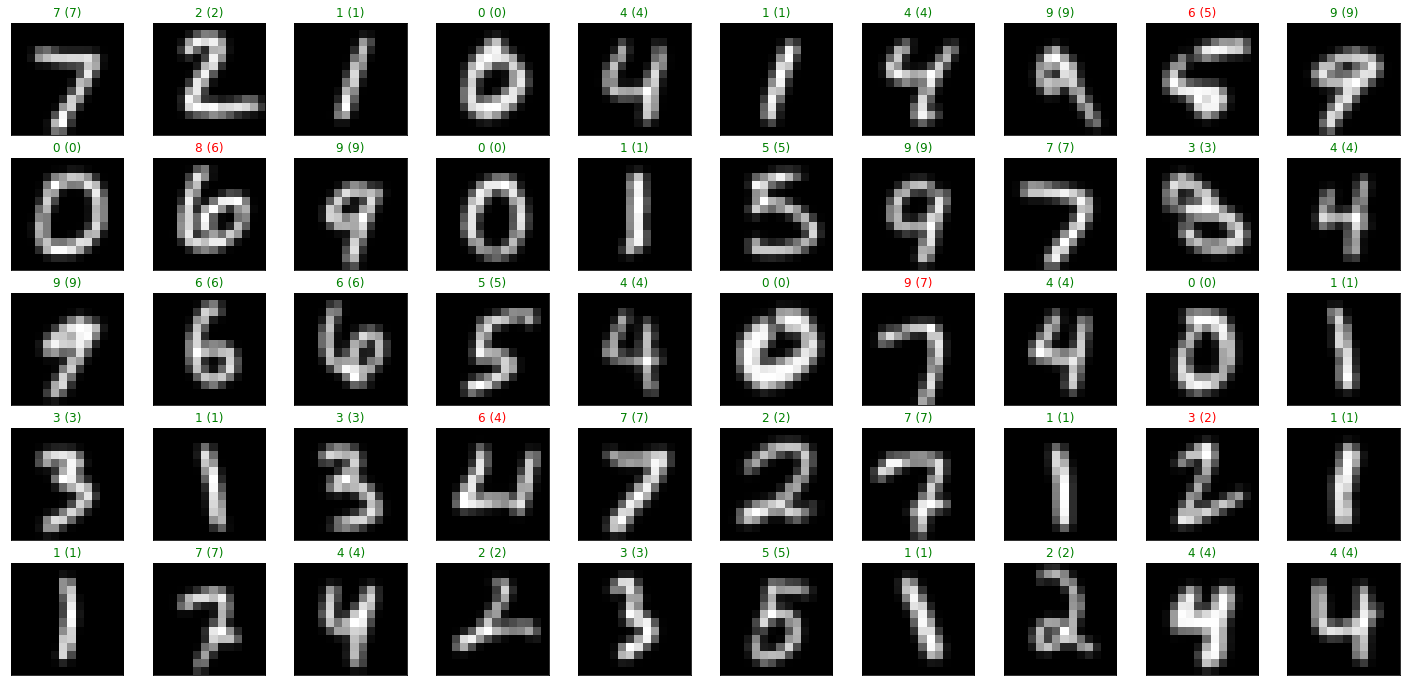

In [47]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 12))
for idx in np.arange(50):
    ax = fig.add_subplot(5, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))